[View in Colaboratory](https://colab.research.google.com/github/You-Your-Yu/machine-learning-assignment/blob/master/Shimosaka_fin_1515309_problem1.ipynb)

# Problem 1

## Dataset 1

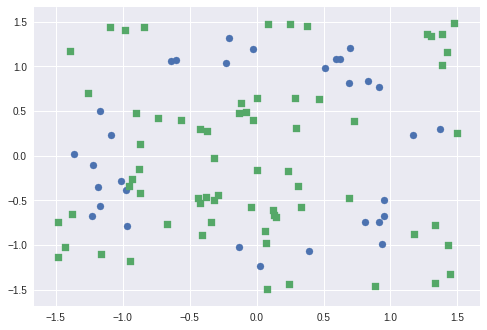

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# dataset 1
def create_dataset1(n=100, bias=False, sd=100):
    np.random.seed(sd)
    # x: n*2行列
    X = 3 * (np.random.rand(n, 2) - 0.5)
    # radius: n*1行列
    radius = X[:,0] ** 2 + X[:,1] ** 2
    # y: n*1行列
    y = np.logical_and((radius > (0.7 + 0.1 * np.random.randn(n, 1))).all(axis=0), (radius < (2.2 + 0.1 * np.random.randn(n, 1))).all(axis=0))
    y = 2 * y - 1
    if bias:
      X = np.c_[X, np.ones(len(X))]
    return X, y

### visualization ###
X, y = create_dataset1()
X_p = X[y == 1]
X_n = X[y == -1]
plt.scatter(X_p[:,0], X_p[:,1], marker='o')
plt.scatter(X_n[:,0], X_n[:,1], marker='s')
plt.show()

## Dataset 2

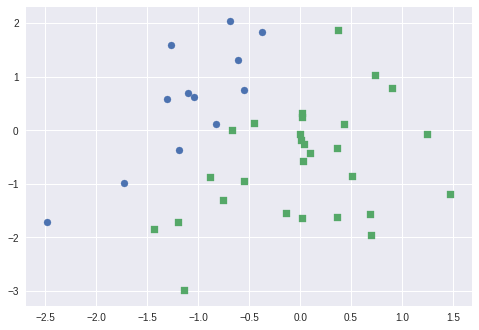

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def create_dataset2(n=40, bias=False,  sd=100):
    np.random.seed(sd)
    omega = np.random.randn(1, 1)
    noise = 0.8 * np.random.randn(n, 1)
    # x: n*2行列
    X = np.random.randn(n, 2)
    # y: n*1行列
    y = 2 * ((omega * X[:,0] + X[:,1] + noise) > 0).all(axis=0) -1
    if bias:
      X = np.c_[X, np.ones(len(X))]
    return X, y

### visualization ###
X, y = create_dataset2()
X_p = X[y == 1]
X_n = X[y == -1]
plt.scatter(X_p[:,0], X_p[:,1], marker='o')
plt.scatter(X_n[:,0], X_n[:,1], marker='s')
plt.show()

## Learning

In [37]:
import numpy as np

# sigmoid function
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

# loss function
def loss(w, X, y, lm=0.1):
  tmp = np.log(1 + np.exp(-np.diag(y).dot(X).dot(w))) # tmp: n * 1
  tmp = np.sum(tmp, axis=0) # tmp: scalar
  tmp += lm * w.T.dot(w) # tmp: scalar
  return tmp

# differentiation of loss function
def d_loss(w, X, y, lm=0.1):
  tmp = np.exp(-np.diag(y).dot(X).dot(w)) # tmp: n * 1
  tmp = -np.diag(y).dot(X) * tmp[:, np.newaxis] / (1 + tmp[:, np.newaxis]) # tmp: n * d
  tmp = np.sum(tmp, axis=0) # tmp: d * 1
  tmp += 2 * lm * w # tmp: d * 1
  return tmp

# Hessian matrix of loss function
def H_loss(w, X, y, lm=0.1):
  tmp = np.exp(-np.diag(y).dot(X).dot(w)) # tmp: n * 1
  tmp /= (1 + tmp)**2 # tmp: n * 1
  tmp = np.diag(y).dot(X) * tmp[:, np.newaxis] # tmp: n * d
  tmp = X.T.dot(np.diag(y)).dot(tmp) # tmp: d * d
  tmp += 2 * lm * np.eye(tmp.shape[0]) # tmp: d * d
  return tmp

# inverse matrix
def inverse(A):
  if np.linalg.det(A) == 0:
    print('error: input matrix is not regular.')
    return np.linalg.det(A)
  d = A.shape[0]
  B = np.empty(A.shape, dtype=float)
  for i in range(d):
    for j in range(d):
      rows = (np.arange(d) != i)
      columns = (np.arange(d) != j)
      tmp = A[rows, :]
      tmp = tmp[:, columns]
      B[i, j] = np.linalg.det(tmp) * (-1) ** (i + j)
  invA = B.T / np.linalg.det(A)
  return invA

# update procedure of batch steepest gradient method
def update_bsg(prev, X, y, lm=0.1, lr=0.1):
  d = d_loss(prev, X, y, lm)
  curr = prev - lr * d
  return curr
  

# update procedure of Newton's method
def update_Newton(prev, X, y, lm=0.1):
  H = H_loss(prev, X, y, lm)
  invH =inverse(H)
  d = d_loss(prev, X, y, lm)
  curr = prev - invH.dot(d)
  return curr

### preparing dataset ###
n = 40
bias = True
train_X, train_y = create_dataset2(n, bias, sd=100)
test_X, test_y = create_dataset2(n, bias, sd=200)
lm = 0.1
fin = 0.001
w_init = np.random.rand(train_X.shape[1]) # use the same initial parameters between two methods
print('train_X: {}, train_y: {}'.format(train_X.shape, train_y.shape))
print('test_X: {}, test_y: {}'.format(test_X.shape, test_y.shape))
print('initial w: {}'.format(w_init))
print('\n')


### batch steepest gradient method ###
lr = 0.01
prev = np.copy(w_init)
log_bsg = [prev]
while True:
  curr = update_bsg(prev, train_X, train_y, lm, lr)
  log_bsg.append(curr)
  if np.linalg.norm(curr - prev) <= fin:
    break
  prev = curr

  
last = log_bsg[-1]
print('--- batch steepest gradient method ---')
print('total steps: {}'.format(len(log_bsg) - 1))
print('train_loss: {:.2f}'.format(loss(last, train_X, train_y, lm)))
print('test_loss: {:.2f}'.format(loss(last, train_X, train_y, lm)))
train_prob = sigmoid(np.dot(train_X, last))
train_pred = np.ones(len(train_y))
train_pred[train_prob < 0.5] = -1
train_acc = np.sum(train_pred == train_y, axis=0) / len(train_y)
test_prob = sigmoid(np.dot(test_X, last))
test_pred = np.ones(len(train_y))
test_pred[test_prob < 0.5] = -1
test_acc = np.sum(test_pred == test_y, axis=0) / len(test_y)
print('tarin_accracy: {:.3f}, test_accuracy: {:.3f}'.format(train_acc, test_acc))
print('optimized w: {}'.format(last))
print('\n')


### Newton's method ###
prev = np.copy(w_init)
log_Newton = [prev]
while True:
  curr = update_Newton(prev, train_X, train_y, lm)
  log_Newton.append(curr)
  if np.linalg.norm(curr - prev) <= fin:
    break
  prev = curr

last = log_Newton[-1]
print('--- Newton\'s method ---')
print('total steps: {}'.format(len(log_Newton) - 1))
print('train_loss: {:.2f}'.format(loss(last, train_X, train_y, lm)))
print('test_loss: {:.2f}'.format(loss(last, train_X, train_y, lm)))
train_prob = sigmoid(np.dot(train_X, last))
train_pred = np.ones(len(train_y))
train_pred[train_prob < 0.5] = -1
train_acc = np.sum(train_pred == train_y, axis=0) / len(train_y)
test_prob = sigmoid(np.dot(test_X, last))
test_pred = np.ones(len(train_y))
test_pred[test_prob < 0.5] = -1
test_acc = np.sum(test_pred == test_y, axis=0) / len(test_y)
print('tarin_accracy: {:.3f}, test_accuracy: {:.3f}'.format(train_acc, test_acc))
print('optimized w: {}'.format(last))
print('\n')

#for i, item in enumerate(log_Newton):
#  print('step: {}'.format(i))
#  print('train_loss: {:.2f}, test_loss: {:.2f}'.format(loss(item, train_X, train_y, lm), loss(item, test_X, test_y, lm)))
#  print('w: {}'.format(item))


train_X: (40, 3), train_y: (40,)
test_X: (40, 3), test_y: (40,)
initial w: [0.69346355 0.32795629 0.13460672]


--- batch steepest gradient method ---
total steps: 456
train_loss: 7.10
test_loss: 7.10
tarin_accracy: 1.000, test_accuracy: 0.925
optimized w: [-3.53826206  2.00476203 -2.69861293]


--- Newton's method ---
total steps: 6
train_loss: 7.09
test_loss: 7.09
tarin_accracy: 1.000, test_accuracy: 0.925
optimized w: [-3.66378798  2.06131645 -2.79797848]




## Visualization

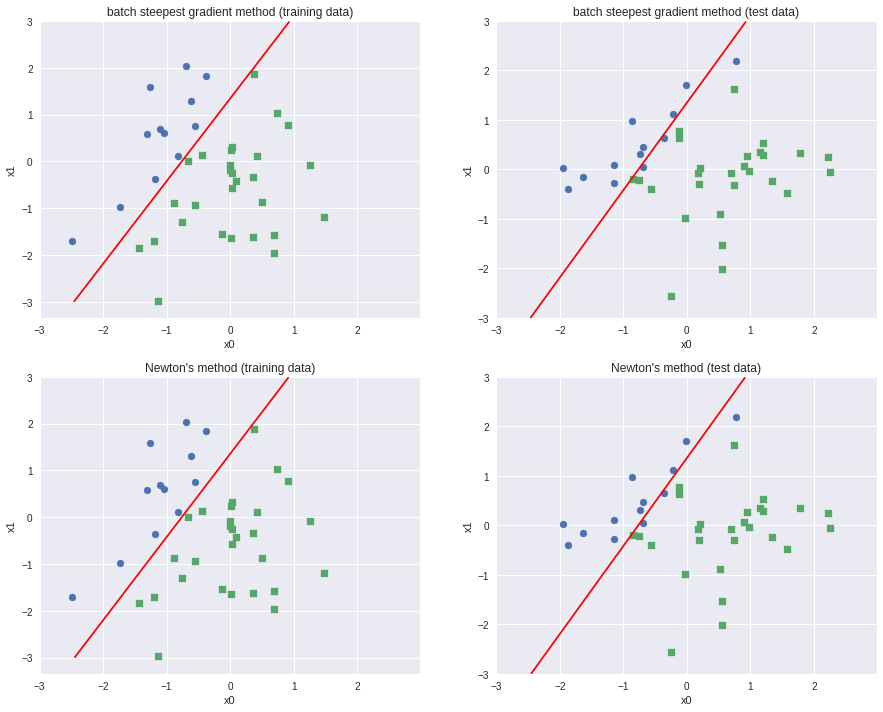

In [38]:
import numpy as np
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

train_X_p = train_X[train_y == 1]
train_X_n = train_X[train_y == -1]
test_X_p = test_X[test_y == 1]
test_X_n = test_X[test_y == -1]

x0range = np.arange(-3, 3, 0.01)
x1range = np.arange(-3, 3, 0.01)
X0, X1 = np.meshgrid(x0range, x1range)

w = log_bsg[-1]
Y = X0 * w[0] + X1 * w[1]
if bias:
  Y += w[2]
ax1.set_title('batch steepest gradient method (training data)')
ax1.set_xlabel('x0')
ax1.set_ylabel('x1')
ax1.contour(X0, X1, Y, [0], colors='red')
ax1.scatter(train_X_p[:,0], train_X_p[:,1], marker='o')
ax1.scatter(train_X_n[:,0], train_X_n[:,1], marker='s')
ax2.set_title('batch steepest gradient method (test data)')
ax2.set_xlabel('x0')
ax2.set_ylabel('x1')
ax2.contour(X0, X1, Y, [0], colors='red')
ax2.scatter(test_X_p[:,0], test_X_p[:,1], marker='o')
ax2.scatter(test_X_n[:,0], test_X_n[:,1], marker='s')

w = log_Newton[-1]
Y = X0 * w[0] + X1 * w[1]
if bias:
  Y += w[2]
ax3.set_title('Newton\'s method (training data)')
ax3.set_xlabel('x0')
ax3.set_ylabel('x1')
ax3.contour(X0, X1, Y, [0], colors='red')
ax3.scatter(train_X_p[:,0], train_X_p[:,1], marker='o')
ax3.scatter(train_X_n[:,0], train_X_n[:,1], marker='s')
ax4.set_title('Newton\'s method (test data)')
ax4.set_xlabel('x0')
ax4.set_ylabel('x1')
ax4.contour(X0, X1, Y, [0], colors='red')
ax4.scatter(test_X_p[:,0], test_X_p[:,1], marker='o')
ax4.scatter(test_X_n[:,0], test_X_n[:,1], marker='s')
plt.show()